## Amazon Rekognition

In following examples, I will show how by using boto3, we can interact with Rekognition service.

We need to start with creating Rekognition client:

In [6]:
import boto3

session = boto3.session.Session()
rekognition_client = session.client('rekognition')

### Detecting labels

In our first example, we will try to detect labels for the following picture:

![kitten](./kitten.jpeg)

To do that, we will use `detect_labels` method, which can accept image as a base64-encoded bytes or reference to image stored in S3 bucket. First, we will try to use kitten image stored in S3 bucket:

In [7]:
import pprint
    
response = rekognition_client.detect_labels(
    Image={
        'S3Object': {
            'Bucket': 'aws-ml-apis',
            'Name': 'rekognition/kitten.jpeg'
        }
    }
)
pprint.pprint(response['Labels'])

[{'Confidence': 89.05464172363281, 'Name': 'Animal'},
 {'Confidence': 89.05464172363281, 'Name': 'Cat'},
 {'Confidence': 89.05464172363281, 'Name': 'Mammal'},
 {'Confidence': 89.05464172363281, 'Name': 'Pet'},
 {'Confidence': 89.05464172363281, 'Name': 'Siamese'},
 {'Confidence': 84.57357788085938, 'Name': 'Abyssinian'},
 {'Confidence': 82.66973114013672, 'Name': 'Kitten'}]


As a part of our response, we got 'Labels', which contain a list of detected labels, with confidence for each of them.

We can also detect labels from our local files, let's try doing that with following local image:

![nature](./nature.jpg)

In [14]:
with open('./nature.jpg', 'rb') as f:
    nature_img = f.read()
    
response = rekognition_client.detect_labels(
    Image={
        'Bytes': nature_img
    }
)
pprint.pprint(response['Labels'])

[{'Confidence': 93.63723754882812, 'Name': 'Animal'},
 {'Confidence': 93.63723754882812, 'Name': 'Bird'},
 {'Confidence': 93.63723754882812, 'Name': 'Cardinal'},
 {'Confidence': 87.85738372802734, 'Name': 'Bird Nest'},
 {'Confidence': 87.85738372802734, 'Name': 'Nest'},
 {'Confidence': 67.46923065185547, 'Name': 'Flora'},
 {'Confidence': 67.46923065185547, 'Name': 'Plant'},
 {'Confidence': 63.8369026184082, 'Name': 'Conifer'},
 {'Confidence': 63.8369026184082, 'Name': 'Tree'},
 {'Confidence': 63.29342269897461, 'Name': 'Blossom'},
 {'Confidence': 63.29342269897461, 'Name': 'Flower'},
 {'Confidence': 62.35154342651367, 'Name': 'Bee Eater'},
 {'Confidence': 59.95719909667969, 'Name': 'Amaryllidaceae'},
 {'Confidence': 54.80449676513672, 'Name': 'Geranium'},
 {'Confidence': 53.9625358581543, 'Name': 'Art'},
 {'Confidence': 53.9625358581543, 'Name': 'Flower Arrangement'},
 {'Confidence': 53.9625358581543, 'Name': 'Ikebana'},
 {'Confidence': 53.9625358581543, 'Name': 'Jar'},
 {'Confidence':

As we can see, there's many more labels, however detect_labels API offers us a few paremeters that can help us clean up response, in following example we're adjusting number of labels and minimal confidence (default is set to 50%).

In [12]:
response = rekognition_client.detect_labels(
    Image={
        'Bytes': nature_img
    },
    MinConfidence=80.0,
    MaxLabels=3
)
pprint.pprint(response['Labels'])

[{'Confidence': 93.63723754882812, 'Name': 'Animal'},
 {'Confidence': 93.63723754882812, 'Name': 'Bird'},
 {'Confidence': 93.63723754882812, 'Name': 'Cardinal'}]


### Detecting faces

Rekognition can also be used to detect faces on provided images, in our example we will try to detect faces on the following image:

![people](./people.jpeg)

Detect faces also supports images passed as a part of request as well as images stored in S3 buckets. In our case we will use image stored in S3 bucket.

In [15]:
response = rekognition_client.detect_faces(
    Image={
        'S3Object': {
            'Bucket': 'aws-ml-apis',
            'Name': 'rekognition/people.jpeg'
        }
    }
)
pprint.pprint(response)

{'FaceDetails': [{'BoundingBox': {'Height': 0.07193230092525482,
                                  'Left': 0.16031746566295624,
                                  'Top': 0.28631874918937683,
                                  'Width': 0.04047619178891182},
                  'Confidence': 99.9825210571289,
                  'Landmarks': [{'Type': 'eyeLeft',
                                 'X': 0.1745094358921051,
                                 'Y': 0.3176249563694},
                                {'Type': 'eyeRight',
                                 'X': 0.1882113665342331,
                                 'Y': 0.3153104782104492},
                                {'Type': 'nose',
                                 'X': 0.17641574144363403,
                                 'Y': 0.3271731436252594},
                                {'Type': 'mouthLeft',
                                 'X': 0.17439544200897217,
                                 'Y': 0.34412097930908203},
                   

By default, it returns a list of details for each detected face such as `BoundingBox`, `Confidence`, `Pose`, `Quality` and `Sharpness`. It can be configured to also return features like `Emotions`, `MouthOpen`, `EyesOpen`, `Mustache`, `Beard`, `Gender`, `Sunglasses`, `Eyeglasses`, `Smile` and `AgeRange`.

To see how well it detect faces, we'll try to mark all detected faces on picture, by using PIL library.

In [26]:
from PIL import Image, ImageDraw

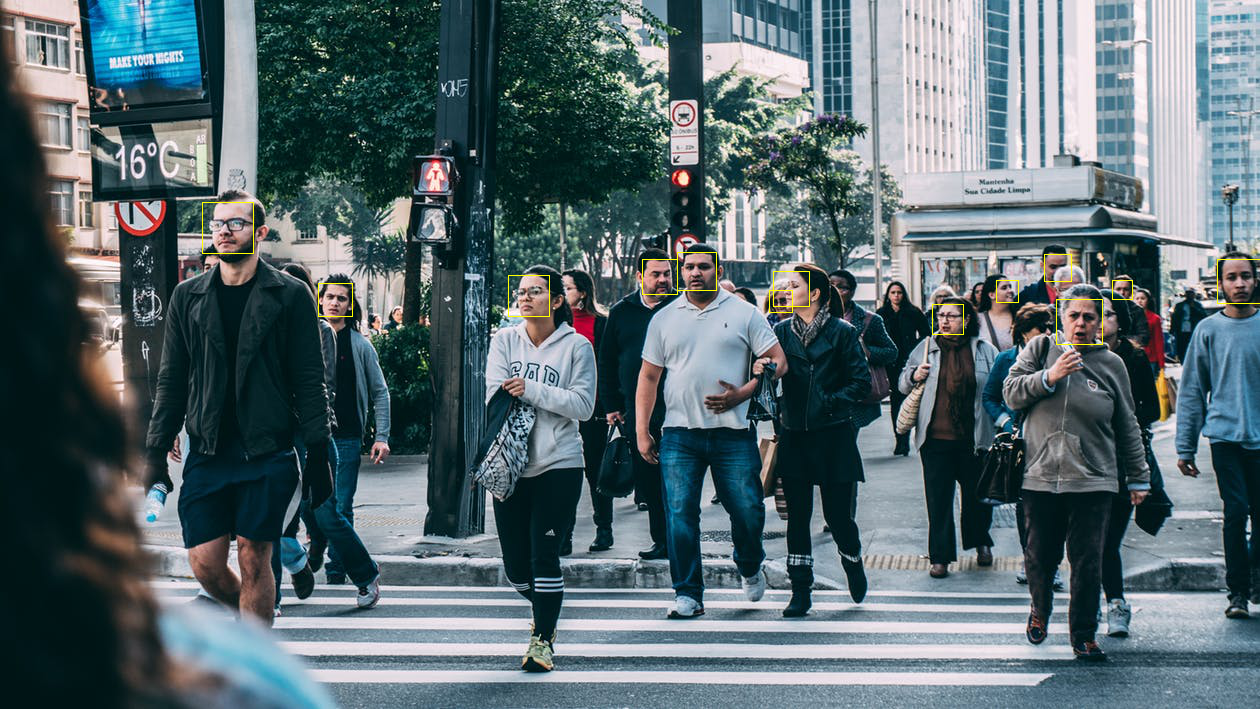

In [30]:
people_img = Image.open('./people.jpeg')

def draw_face_bounding_box(image, face_details):
    left = (int)(image.width * face_details['BoundingBox']['Left'])
    top = (int)(image.height * face_details['BoundingBox']['Top'])
    right = (int)(left + image.width * face_details['BoundingBox']['Width'])
    bottom = (int)(top + image.height * face_details['BoundingBox']['Height'])
    img_draw = ImageDraw.Draw(image)
    img_draw.rectangle([left, top, right, bottom], None, 'yellow')

for face_details in response['FaceDetails']:
    draw_face_bounding_box(people_img, face_details)

people_img

In our case, Rekognition did pretty good job, detecting almost every visible face.

### Recognize celebrities

Rekognition is also able to recognize celebrities on provided images. In our example, we will use famous celebrities selfie from Oscars.

![oscars](./oscars.jpg)

In [34]:
response = rekognition_client.recognize_celebrities(
    Image={
        'S3Object': {
            'Bucket': 'aws-ml-apis',
            'Name': 'rekognition/oscars.jpg'
        }
    }
)
pprint.pprint(response)

{'CelebrityFaces': [{'Face': {'BoundingBox': {'Height': 0.4540059268474579,
                                              'Left': 0.46410685777664185,
                                              'Top': 0.4094955623149872,
                                              'Width': 0.2570951581001282},
                              'Confidence': 99.99984741210938,
                              'Landmarks': [{'Type': 'eyeLeft',
                                             'X': 0.543455958366394,
                                             'Y': 0.5915051698684692},
                                            {'Type': 'eyeRight',
                                             'X': 0.630245566368103,
                                             'Y': 0.583631694316864},
                                            {'Type': 'nose',
                                             'X': 0.5753805637359619,
                                             'Y': 0.6611990332603455},
                           

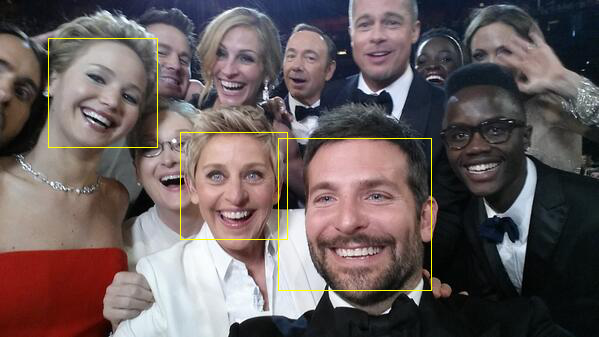

In [37]:
oscars_img = Image.open('./oscars.jpg')

for celebrity in response['CelebrityFaces']:
    draw_face_bounding_box(oscars_img, celebrity['Face'])

## TODO: ADD DRAWING UNRECOGNIZED FACES
    
oscars_img

It only detected three celebrities, so it's not that good with detecting celebrities that are not in front of the picture. Let's try with a bit more difficult and also famous picture:

![jobs-gates](./jobs-gates.jpeg)

In [38]:
response = rekognition_client.recognize_celebrities(
    Image={
        'S3Object': {
            'Bucket': 'aws-ml-apis',
            'Name': 'rekognition/jobs-gates.jpeg'
        }
    }
)
pprint.pprint(response)

{'CelebrityFaces': [{'Face': {'BoundingBox': {'Height': 0.14869888126850128,
                                              'Left': 0.6895833611488342,
                                              'Top': 0.0706319734454155,
                                              'Width': 0.0833333358168602},
                              'Confidence': 99.9198226928711,
                              'Landmarks': [{'Type': 'eyeLeft',
                                             'X': 0.7140507102012634,
                                             'Y': 0.1286371946334839},
                                            {'Type': 'eyeRight',
                                             'X': 0.7370059490203857,
                                             'Y': 0.1177583709359169},
                                            {'Type': 'nose',
                                             'X': 0.7182610034942627,
                                             'Y': 0.14864590764045715},
                        

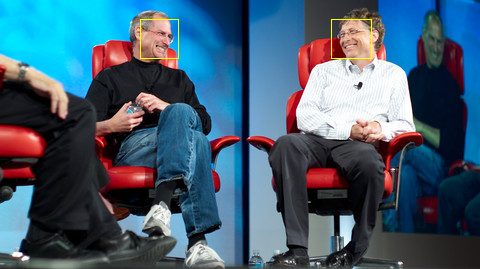

In [39]:
jobs_gates_img = Image.open('./jobs-gates.jpeg')

for celebrity in response['CelebrityFaces']:
    draw_face_bounding_box(jobs_gates_img, celebrity['Face'])
    
jobs_gates_img

As we can see Rekognition didn't have any problems recognizing Steve Jobs and Bill Gates, even 